# Analysis of trained networks to determine threshold for gunshots

In [20]:
import argparse
import eons
import neuro
import risp
import speech2spikes
import os
import torchaudio
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
from multiprocessing import shared_memory
import signal
import time
import functools
import json
from common import risp_config, read_spikes_from_disk, network_details
import matplotlib.pyplot as plt

DATASET_PATH = './data/1200-dwt-gunshot-data.npz'
NETWORK_PATH = './tbest.json'
PROC_RUN_TIMESTEPS = 2000
MODE = 'dwt'

In [21]:
proc = risp.Processor(risp_config)

train_spikes, train_labels, train_gunshot_data, val_spikes, val_labels, val_gunshot_data, _, _ = read_spikes_from_disk(DATASET_PATH)

In [22]:
network = neuro.Network()
with open(NETWORK_PATH, 'r') as f:
    net_json = json.load(f)
network.from_json(net_json)

proc.load_network(network)

True

In [23]:
def compute_fitness(spikes, labels, gunshot_data, reconstruct_spikes=False):
    if reconstruct_spikes:
        rec_spikes = []

        if MODE == 's2s':
            for i in range(len(spikes)):
                rec_spikes.append([])

                for j in range(len(spikes[i])):
                    rec_spikes[i].append([])
                    
                    for spk in spikes[i][j]:
                        if spk[2] == 1:
                            rec_spikes[i][j].append(neuro.Spike(spk[0], spk[1], spk[2]))
                    
        elif MODE == 'samples':
            for i in range(len(spikes)): 
                rec_spikes.append([])
                
                for j in range(len(spikes[0])):
                    # id, time, value
                    rec_spikes[i].append(neuro.Spike(0, j, spikes[i][j]))

        elif MODE == 'dwt':
            for i in range(spikes.shape[0]):
                rec_spikes.append([])

                for j in range(spikes.shape[1]):
                    rec_spikes[i].append([])

                    for k in range(spikes.shape[2]):
                        #print(f'Creating Spike({j}, {k}, {shared_spikes_arr[i][j][k]})')
                        rec_spikes[i][j].append(neuro.Spike(j, k, spikes[i][j][k]))

        spikes = rec_spikes

    timesteps_from_data = len(spikes[0][0]) if MODE != 'samples' else 24000
    
    #differences = [] # track difference between gunshot and background neurons while gunshot is active
    
    # NOTE: has new meaning here (compared to train_script.py): just the total number of gunshot output neuron spikes regardless of label
    gunshot_spikes = [] # each entry is tuple where (label, gunshot_spikes) 
    for i in range(len(spikes)):
        proc.clear_activity()

        # apparently clear_activity resets this
        proc.track_output_events(0)
        proc.track_output_events(1)

        if MODE == 's2s' or MODE == 'dwt' or MODE == 'spec':
            for c in spikes[i]: # spikes[i] is a single training sample
                proc.apply_spikes(c)
        elif MODE == 'samples':
            proc.apply_spikes(spikes[i])

        proc.run(PROC_RUN_TIMESTEPS)
        gunshot_spikes.append((int(labels[i]), proc.output_counts()[1]))
        # # translation from time (0-2s) to timesteps
        # if labels[i] == 1:
        #     secs_per_timestep = 2 / timesteps_from_data
        #     active_between = gunshot_data[i] / secs_per_timestep # timesteps of input where gunshot audio is active

        #     # I am pretty sure that all gunshots start at a point, then go until/beyond the end of 2s in every scenario
        #     # due to how data is generated
        #     active_between[1] = timesteps_from_data

        #     active_between = active_between.astype(np.int64)
        # else:
        #     active_between = [0, PROC_RUN_TIMESTEPS]

        # proc.run(PROC_RUN_TIMESTEPS)

        # vec_0, vec_1 = proc.output_vectors()

        # vec_0_count = 0
        # for s in vec_0:
        #     if s >= active_between[0] and s <= active_between[1]:
        #         vec_0_count += 1

        # vec_1_count = 0
        # for s in vec_1:
        #     if s >= active_between[0] and s <= active_between[1]:
        #         vec_1_count += 1

        # if labels[i] == 1:
        #     differences.append(vec_1_count-vec_0_count)
        # else:
        #     gunshot_spikes.append(len(vec_1))
    
    # idea here is that the first term pushes our networks towards those that can differentiate between gunshots and noise the most 
    # while gunshot is happening, in combination with being able to not spike the gunshot neuron as much when only background sounds are happening
    return np.array(gunshot_spikes)

In [24]:
gunshot_spikes = compute_fitness(val_spikes, val_labels, val_gunshot_data, reconstruct_spikes=True)

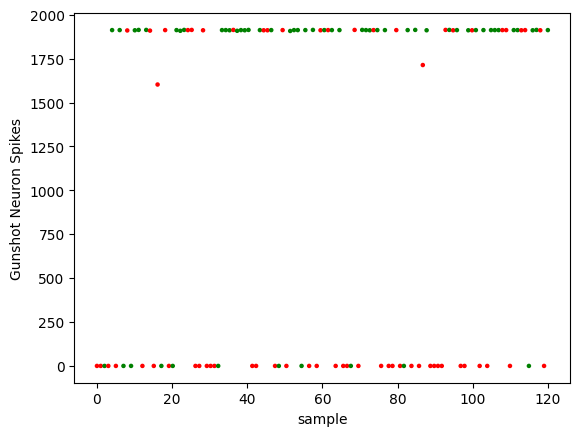

In [25]:
plt.xlabel('sample')
plt.ylabel('Gunshot Neuron Spikes')

plt.scatter(np.linspace(0, len(gunshot_spikes), len(gunshot_spikes)), [i[1] for i in gunshot_spikes],
            c=['green' if i == 1 else 'red' for i in val_labels], s=5)

In [26]:
# pretty clear threshold
# now let's compute accuracy
correct = 0
fn, fp = 0, 0
total = len(val_labels)
THRESHOLD = 1750

for i in range(total):
    if val_labels[i] == 1 and gunshot_spikes[i, 1] > THRESHOLD:
        correct += 1
    elif val_labels[i] == 1 and gunshot_spikes[i, 1] <= THRESHOLD:
        fn += 1
    elif val_labels[i] == 0 and gunshot_spikes[i, 1] <= THRESHOLD:
        correct += 1
    elif val_labels[i] == 0 and gunshot_spikes[i, 1] > THRESHOLD:
        fp += 1

print(f'{correct/total:.3f} accuracy {correct} out of {total}')
print(f'False positive count: {fp}')
print(f'False negative count: {fn}')

0.717 accuracy 86 out of 120
False positive count: 23
False negative count: 11
